# FIAP Bootcamp - Wtec Suprimentos - Classificação de Novos Clientes
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 3: Classificação de Novos Clientes
- Um problema Jä mapeado é o que fazer apos a geracäo desses grupos quando chegar um novo cliente solicitando um novo crédito?
- Como seria possivel indicar o grupo desse cliente sem ter que refazer todos os grupos?

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado capaz de classificar automaticamente novos clientes com base na segmentação atualmente existente
- Será utilizado um algoritmo supervisionado para essa classificação, baseado nas segmentações obtidas no modelo de clusterização
- Serão explorados os dois cenários propostos até o momento, e ambos serão comparados ao final:
	- cenário 1: utilizando informações do cliente disponíveis sem a exigência das documentações contábeis
	- cenário 2: utilizando informações disponíveis nas documentações contábeis

### Setup

In [25]:
# dados / io
import pandas as pd
import pandas_flavor as pf
import numpy as np
import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# otimização
from sklearnex import patch_sklearn
patch_sklearn()
# preprocessamento
from sklearn.preprocessing import StandardScaler
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# seleção de modelos
import optuna as opt
opt.logging.set_verbosity(opt.logging.WARNING)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
# display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=opt.exceptions.ExperimentalWarning)
pd.options.display.float_format = '{:,.4f}'.format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Carga de Dados

In [11]:
data = pd.read_csv('solicitacoescredito_segmentada.csv')
data.sample(5).T

,5337,6984,8476,8590,8454
numero_solicitacao,"5,410.00","7,057.00","8,549.00","8,663.00","8,527.00"
razaoSocial,Melanie Clarke,Nicola Turnbull,Nicola Lewis,Malcolm Rose,Alexandra Jones
nomeFantasia,Elliot Thomas,Hazel Dennis,Katy Stephens-Stephens,Eleanor Brooks,Joseph Smith
cnpjSemTraco,HFFS88074547051205,XYOK79084874197647,DBEX30187767811342,RRIJ52218887558264,FOEE36407635078532
maiorAtraso,37,3,0,0,0
margemBrutaAcumulada,0.29,0.30,0.57,0.28,1.00
percentualProtestos,0.00,0.00,0.00,0.00,0.00
primeiraCompra,2018-09-28T00:00:00,2018-10-10T00:00:00,2021-01-28T00:00:00,2017-02-16T00:00:00,2020-12-15T00:00:00
prazoMedioRecebimentoVendas,0,0,0,0,0
titulosEmAberto,0.00,0.00,0.00,0.00,0.00


### Pre-Processamento

#### filtro

In [12]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame, # dataframe com a coluna 'status'
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"7,201.00","4,562.63","2,601.48",1.00,"2,353.00","4,585.00","6,827.00","9,034.00"
maiorAtraso,"7,201.00",24.37,64.03,0.00,3.00,6.00,22.00,977.00
margemBrutaAcumulada,"7,201.00",0.37,0.20,0.00,0.29,0.41,0.51,1.00
percentualProtestos,"6,057.00",0.01,0.56,0.00,0.00,0.00,0.00,36.98
prazoMedioRecebimentoVendas,"7,201.00",24.19,71.06,0.00,0.00,0.00,32.00,"1,605.00"
titulosEmAberto,"7,201.00","61,165.54","216,805.22",0.00,0.00,0.00,"18,605.30","2,836,656.00"
valorSolicitado,"7,201.00","480,475.47","15,912,896.04","3,000.00","25,000.00","50,000.00","130,000.00","1,200,000,000.00"
diferencaPercentualRisco,"7,201.00",0.74,0.13,0.26,0.64,0.75,0.85,1.00
percentualRisco,"7,201.00",0.26,0.13,0.00,0.15,0.25,0.36,0.74
dashboardCorrelacao,"7,201.00",0.04,0.50,-1.00,0.00,0.00,0.00,1.00


#### feature engineering

In [13]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

data.filter_status().engineer().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            7201 non-null   float64       
 1   razaoSocial                   7201 non-null   object        
 2   nomeFantasia                  7201 non-null   object        
 3   cnpjSemTraco                  7201 non-null   object        
 4   maiorAtraso                   7201 non-null   int64         
 5   margemBrutaAcumulada          7201 non-null   float64       
 6   percentualProtestos           6057 non-null   float64       
 7   primeiraCompra                7159 non-null   object        
 8   prazoMedioRecebimentoVendas   7201 non-null   int64         
 9   titulosEmAberto               7201 non-null   float64       
 10  valorSolicitado               7201 non-null   float64       
 11  status                        

#### seleção de features

In [14]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	keep = [
			# 'percentualRisco',
			# 'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			'faturamentoMensal',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			'margem_percentual',
			'maiorAtraso',
			'prazo_medio_cobranca',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'titulosEmAberto',
			'cluster',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return data[intersection]
data.filter_status().engineer().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster                      6631 non-null   float64
 1   faturamentoMensal            7201 non-null   float64
 2   restricoes                   7201 non-null   object 
 3   tempoPrimeiraCompra          6631 non-null   float64
 4   prazoMedioRecebimentoVendas  7201 non-null   int64  
 5   empresa_MeEppMei             7201 non-null   object 
 6   titulosEmAberto              7201 non-null   float64
 7   anoFundacao                  7201 non-null   float64
 8   maiorAtraso                  7201 non-null   int64  
 9   scorePontualidade            7201 non-null   float64
 10  margem_percentual            7201 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 675.1+ KB


#### data types

In [15]:
# converte data types
@pf.register_dataframe_method
def type_cast(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	for col in X.columns:
		if col in ['cluster1', 'cluster2']:
			X[col] = X[col].astype('int32', errors='ignore')
		else:
			X[col] = X[col].astype('float32')		
	return X
data.filter_status().engineer().select().type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster                      6631 non-null   float32
 1   faturamentoMensal            7201 non-null   float32
 2   restricoes                   7201 non-null   float32
 3   tempoPrimeiraCompra          6631 non-null   float32
 4   prazoMedioRecebimentoVendas  7201 non-null   float32
 5   empresa_MeEppMei             7201 non-null   float32
 6   titulosEmAberto              7201 non-null   float32
 7   anoFundacao                  7201 non-null   float32
 8   maiorAtraso                  7201 non-null   float32
 9   scorePontualidade            7201 non-null   float32
 10  margem_percentual            7201 non-null   float32
dtypes: float32(11)
memory usage: 365.7 KB


#### limpeza

In [16]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().engineer().select().type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster                      6631 non-null   float32
 1   faturamentoMensal            6631 non-null   float32
 2   restricoes                   6631 non-null   float32
 3   tempoPrimeiraCompra          6631 non-null   float32
 4   prazoMedioRecebimentoVendas  6631 non-null   float32
 5   empresa_MeEppMei             6631 non-null   float32
 6   titulosEmAberto              6631 non-null   float32
 7   anoFundacao                  6631 non-null   float32
 8   maiorAtraso                  6631 non-null   float32
 9   scorePontualidade            6631 non-null   float32
 10  margem_percentual            6631 non-null   float32
dtypes: float32(11)
memory usage: 336.7 KB


#### padronização

In [18]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = StandardScaler()
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().engineer().select().type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
cluster,"6,631.00",0.00,1.00,-1.36,-1.36,0.43,0.43,1.62
faturamentoMensal,"6,631.00",-0.00,1.00,-0.28,-0.27,-0.25,-0.16,7.90
restricoes,"6,631.00",0.00,1.00,-0.24,-0.24,-0.24,-0.24,4.10
tempoPrimeiraCompra,"6,631.00",-0.00,1.00,-1.19,-0.78,-0.31,0.59,2.43
prazoMedioRecebimentoVendas,"6,631.00",-0.00,1.00,-0.51,-0.51,-0.51,0.26,5.20
empresa_MeEppMei,"6,631.00",0.00,1.00,-0.78,-0.78,-0.78,1.29,1.29
titulosEmAberto,"6,631.00",0.00,1.00,-0.33,-0.33,-0.33,-0.21,5.96
anoFundacao,"6,631.00",0.00,1.00,-3.41,-0.57,0.26,0.81,1.18
maiorAtraso,"6,631.00",0.00,1.00,-0.52,-0.44,-0.37,-0.01,6.22
scorePontualidade,"6,631.00",-0.00,1.00,-2.29,0.29,0.50,0.50,0.50


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foram testados 3 algoritmos diferentes de classificação<br>
- para cada algoritmo, foram testadas as principais variações dos seus hiperparâmetros<br>
- a busca foi feita por otimização bayesiana, utilizando validação cruzada com 5 partições <br>
- todas as métricas de avaliação foram feitas no conjunto de teste (holdout) <br>
- o particionamento do conjunto de teste foi feito com 20% dos registros disponíveis
</td></tr></table></div>

#### preprocessamento

In [22]:
data_preprocess = data.filter_status().engineer().select().type_cast().clean().copy()
targets_preprocess = data_preprocess['cluster']
features_preprocess = data_preprocess.drop(columns=['cluster']).standardize()

data_train, data_test, targets_train, targets_test = train_test_split(features_preprocess, targets_preprocess, test_size=0.2, random_state=42)

display(data_train.describe().T)
display(targets_train.value_counts())

,count,mean,std,min,25%,50%,75%,max
faturamentoMensal,"5,304.00",0.02,1.05,-0.28,-0.27,-0.25,-0.15,7.90
restricoes,"5,304.00",-0.00,1.00,-0.24,-0.24,-0.24,-0.24,4.10
tempoPrimeiraCompra,"5,304.00",0.01,1.01,-1.19,-0.78,-0.31,0.61,2.43
prazoMedioRecebimentoVendas,"5,304.00",0.00,1.00,-0.51,-0.51,-0.51,0.26,5.20
empresa_MeEppMei,"5,304.00",-0.01,1.00,-0.78,-0.78,-0.78,1.29,1.29
titulosEmAberto,"5,304.00",0.00,1.00,-0.33,-0.33,-0.33,-0.21,5.96
anoFundacao,"5,304.00",-0.01,1.01,-3.41,-0.57,0.26,0.81,1.18
maiorAtraso,"5,304.00",0.00,1.00,-0.52,-0.44,-0.37,-0.01,6.22
scorePontualidade,"5,304.00",0.01,0.99,-2.29,0.31,0.50,0.50,0.50
margem_percentual,"5,304.00",0.01,1.01,-0.81,-0.81,-0.81,0.69,2.98


3.00    1794
0.00    1383
2.00     750
5.00     668
4.00     385
1.00     324
Name: cluster, dtype: int64

### Treinamento

#### rotinas de otimização

In [19]:
# callback para salvar o melhor modelo
def callback(
		study: opt.study.Study,
		trial: opt.trial.FrozenTrial,
	) -> None:
	if study.best_trial.number == trial.number:
		study.set_user_attr(key="best_estimator", value=trial.user_attrs["estimator"])

In [20]:
# plota os resultados da otimização e a avaliação do melhor modelo no dataset de teste
def plot_optimization_results(
		study: opt.study.Study,
		y_test: pd.DataFrame,
		y_pred: np.ndarray,
	) -> None:

	# plota os resultados da otimização
	display(opt.visualization.plot_optimization_history(study))
	try:
		display(opt.visualization.plot_param_importances(study))
	except:
		...
	
	# exibe os resultados
	# results = study.trials_dataframe()
	# results = results.drop(columns=['datetime_start', # 'user_attrs_best_estimator',
	# 	'datetime_complete', 'duration', 'state'])
	# display(results.head(10))

	# imprime o melhor modelo
	print (f'Best trial: {study.best_trial.value}')
	print (f'Best parameters: {study.best_params}')

	# matriz de confusão
	print(classification_report(y_test, y_pred))
	disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))#, display_labels=fit.classes_)
	disp.plot()
	plt.show()
	
	# curva ROC
	# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
	# roc_auc = auc(fpr, tpr)
	# disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) #, estimator_name='example estimator')
	# display.plot()


In [23]:
# rotina de otimização bayesiana
def optimize(
		objective, #Callable,
    description: str,
    n_trials: int,
		X: pd.DataFrame,
		y: pd.DataFrame,
		X_test: pd.DataFrame,
		y_test: pd.DataFrame,
	) -> dict: 
        
	# cria o estudo e executa a otimização
	study = opt.create_study(direction='maximize')
	study.optimize(lambda trial:objective(trial, X, y),
		callbacks=[callback], n_trials=n_trials, timeout=60*5, n_jobs=-1, show_progress_bar = True)

	# fita e salva o melhor modelo
	fit = study.user_attrs["best_estimator"].fit(X, y)
	joblib.dump(fit, f'models/{description}.joblib')

	# avalia os resultados no conjunto de teste
	y_pred = fit.predict(X_test)

	# plota os resultados
	plot_optimization_results(study, y_test, y_pred)
	
	return {
		'description': description,
		'estimator': fit,
		'results': study.trials_dataframe(),
		'predictions': y_pred,
	}


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
foi necessário utilizar pesos para lidar com o desequilibrio das classes
</td></tr></table></div>

#### regressão logística

  0%|          | 0/39 [00:00<?, ?it/s]

Best trial: 0.992082229295965
Best parameters: {'C': 19329413.488444824, 'l1_ratio': 0.5823613212548017, 'fit_intercept': True}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       366
         1.0       0.99      1.00      0.99        76
         2.0       0.99      0.99      0.99       155
         3.0       1.00      0.99      1.00       445
         4.0       0.99      1.00      1.00       100
         5.0       0.99      1.00      1.00       185

    accuracy                           1.00      1327
   macro avg       0.99      1.00      0.99      1327
weighted avg       1.00      1.00      1.00      1327



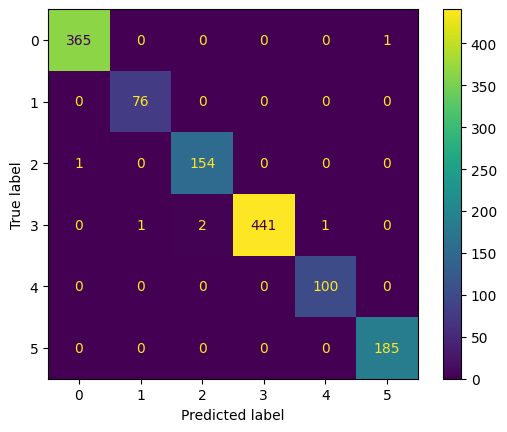

In [26]:
# define o espaço de busca e a função objetivo
def objective_logistic_regression(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = LogisticRegression(
		penalty = 'elasticnet', solver='saga',
		class_weight='balanced', # equilibra as classes
		C=trial.suggest_float('C', 1e-10, 1e+10, log=True),
		l1_ratio=trial.suggest_float('l1_ratio', 0, 1),
		fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
logistic_regression_model = optimize(
	objective=objective_logistic_regression, 
	description='logistic_regression', n_trials=39,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### árvore de decisão

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0.9079919264488823
Best parameters: {'criterion': 'entropy', 'min_samples_split': 0.023, 'min_samples_leaf': 0.01}
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       366
         1.0       0.96      0.57      0.71        76
         2.0       0.75      0.75      0.75       155
         3.0       0.94      0.97      0.95       445
         4.0       0.87      0.77      0.81       100
         5.0       0.94      0.94      0.94       185

    accuracy                           0.90      1327
   macro avg       0.89      0.83      0.85      1327
weighted avg       0.90      0.90      0.90      1327



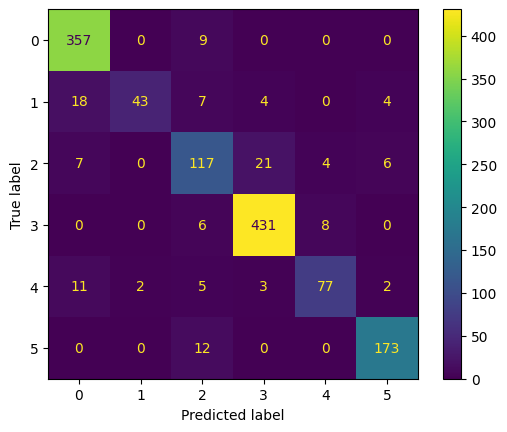

In [27]:
# define o espaço de busca e a função objetivo
def objective_decision_tree(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:	
	estimator = DecisionTreeClassifier(
		criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
		min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.4, log=False, step=0.001),
		min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.2, log=False, step=0.001),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

# rotina de otimização bayesiana
decision_tree_model = optimize(
	objective=objective_decision_tree, 
	description='decision_tree_classifier', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### naive bayes

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0.9409890989276761
Best parameters: {'var_smoothing': 0.15977188405748916}
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       366
         1.0       0.96      1.00      0.98        76
         2.0       0.97      0.68      0.80       155
         3.0       0.91      0.98      0.95       445
         4.0       0.95      0.93      0.94       100
         5.0       0.98      0.99      0.99       185

    accuracy                           0.95      1327
   macro avg       0.96      0.93      0.94      1327
weighted avg       0.95      0.95      0.95      1327



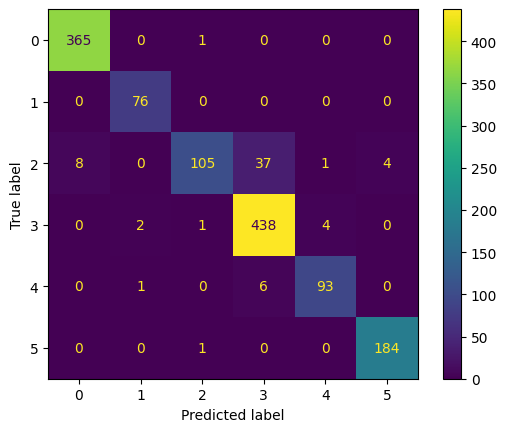

In [28]:
# define o espaço de busca e a função objetivo
def objective_naive_bayes(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:	
	estimator = GaussianNB(
		var_smoothing = trial.suggest_float('var_smoothing', 1e-15, 1, log=True),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

# rotina de otimização bayesiana
naive_bayes_model = optimize(
	objective=objective_naive_bayes, 
	description='naive_bayes_classifier', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### comparação de modelos

In [29]:
models = [logistic_regression_model, decision_tree_model, naive_bayes_model]
for model in models:
	print (f'{model["description"]}: {model["estimator"].score(data_test, targets_test)}')

logistic_regression: 0.9954785229841748
decision_tree_classifier: 0.9027882441597589
naive_bayes_classifier: 0.9502637528259231


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
O modelo de regressão logística apresentou resultados quase perfeitos no dataset de teste.
</td></tr></table></div>

#### importância das features

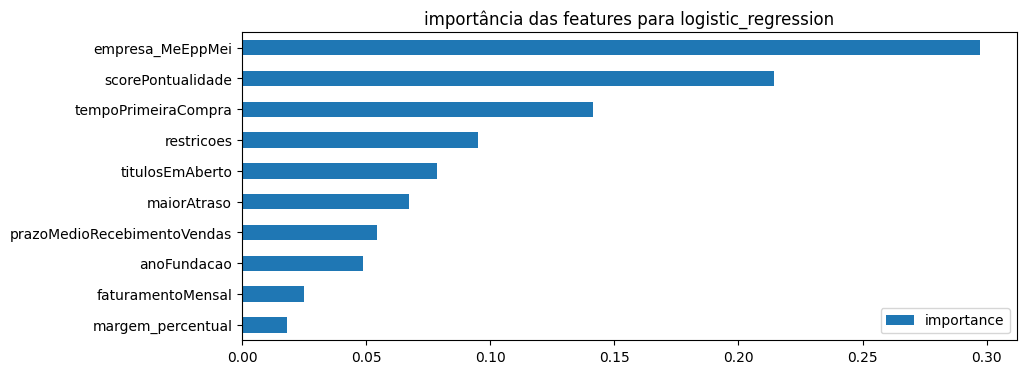

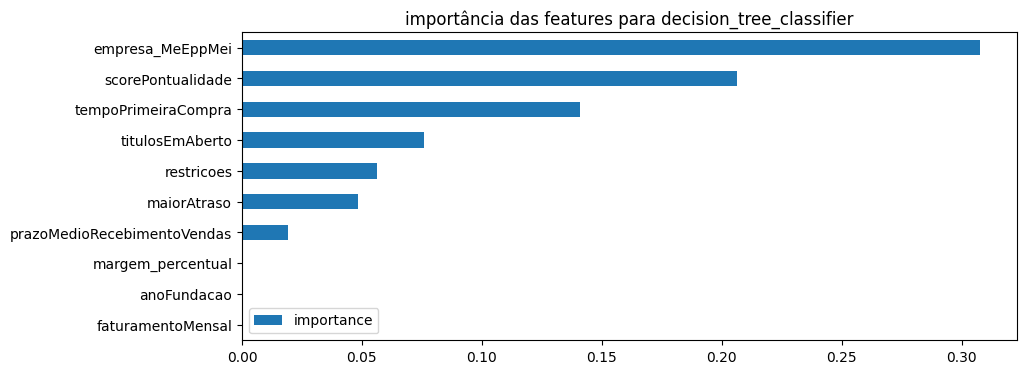

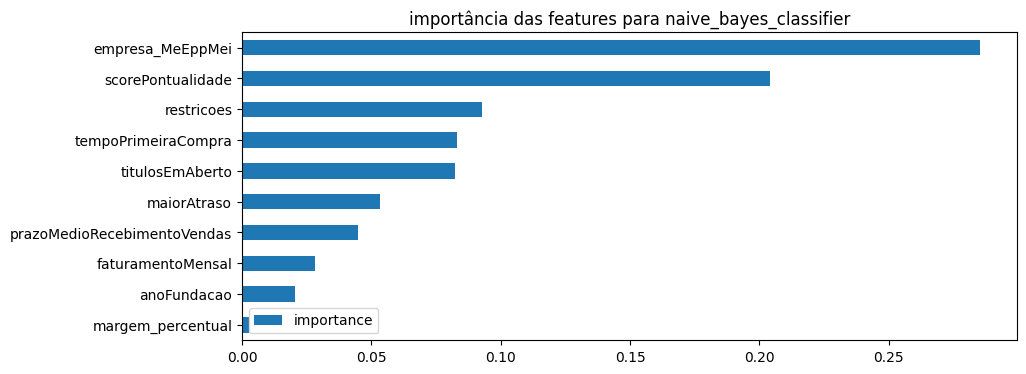

In [30]:
def plot_feature_importances(
		model: dict,
		X: pd.DataFrame,
		y: pd.DataFrame,
		) -> None:
	importances = permutation_importance(model['estimator'], X, y, n_repeats=10)
	table = pd.DataFrame(importances.importances_mean, index=X.columns, columns=['importance'])
	table.sort_values(by='importance', ascending=True, inplace=True)
	table.plot.barh(figsize=(10, 3+int(table.shape[0]/6)))
	plt.title(f'importância das features para {model["description"]}')
	plt.show()

for model in models:
	plot_feature_importances(model, data_train, targets_train)


### Conclusão

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
o modelo escolhido, regressão logística, utilizou corretamente as features disponíveis para identificar o segmento dos clientes, apresentando uma acurácia de 99%
</td></tr></table></div>